In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import os
import json

# Define the path to the uploaded zip file and extract directory
zip_path = "/content/drive/MyDrive/Assignment/RM_Segmentation_Assignment_dataset.zip"
extract_dir = "/content/drive/MyDrive/Assignment/RM_Segmentation_Assignment_dataset"

# Load the labels.json file from training data
labels_json_path = os.path.join(extract_dir, "train-300", "labels.json")
with open(labels_json_path, 'r') as f:
    train_labels = json.load(f)

# Extract and show all categories
categories = train_labels.get("categories", [])
category_summary = {cat["id"]: cat["name"] for cat in categories}

category_summary

{0: 'airplane',
 1: 'backpack',
 2: 'banana',
 3: 'baseball bat',
 4: 'baseball glove',
 5: 'bear',
 6: 'bench',
 7: 'bicycle',
 8: 'bird',
 9: 'boat',
 10: 'book',
 11: 'bottle',
 12: 'bowl',
 13: 'broccoli',
 14: 'bus',
 15: 'cake',
 16: 'car',
 17: 'carrot',
 18: 'cat',
 19: 'cell phone',
 20: 'chair',
 21: 'clock',
 22: 'cow',
 23: 'cup',
 24: 'dining table',
 25: 'dog',
 26: 'donut',
 27: 'elephant',
 28: 'fire hydrant',
 29: 'fork',
 30: 'frisbee',
 31: 'giraffe',
 32: 'handbag',
 33: 'horse',
 34: 'hot dog',
 35: 'kite',
 36: 'knife',
 37: 'laptop',
 38: 'motorcycle',
 39: 'oven',
 40: 'parking meter',
 41: 'person',
 42: 'pizza',
 43: 'potted plant',
 44: 'refrigerator',
 45: 'remote',
 46: 'sandwich',
 47: 'scissors',
 48: 'skateboard',
 49: 'skis',
 50: 'spoon',
 51: 'sports ball',
 52: 'stop sign',
 53: 'suitcase',
 54: 'surfboard',
 55: 'tennis racket',
 56: 'tie',
 57: 'traffic light',
 58: 'train',
 59: 'truck',
 60: 'umbrella',
 61: 'vase',
 62: 'wine glass'}

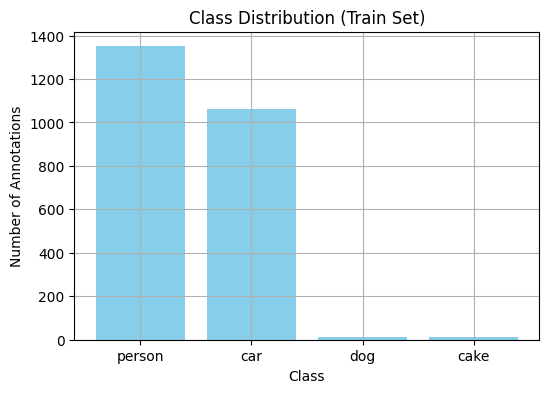

In [74]:
import json
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

# Path to labels
label_path = "/content/drive/MyDrive/Assignment/RM_Segmentation_Assignment_dataset/train-300/labels.json"

# Load annotations
with open(label_path, "r") as f:
    data = json.load(f)

annotations = data["annotations"]
categories = {cat["id"]: cat["name"] for cat in data["categories"]}

target_ids = {15: "cake", 16: "car", 25: "dog", 41: "person"}

# Class Distribution
class_counts = Counter()
for ann in annotations:
    if ann["category_id"] in target_ids:
        class_counts[target_ids[ann["category_id"]]] += 1

plt.figure(figsize=(6, 4))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title("Class Distribution (Train Set)")
plt.xlabel("Class")
plt.ylabel("Number of Annotations")
plt.grid(True)
plt.show()

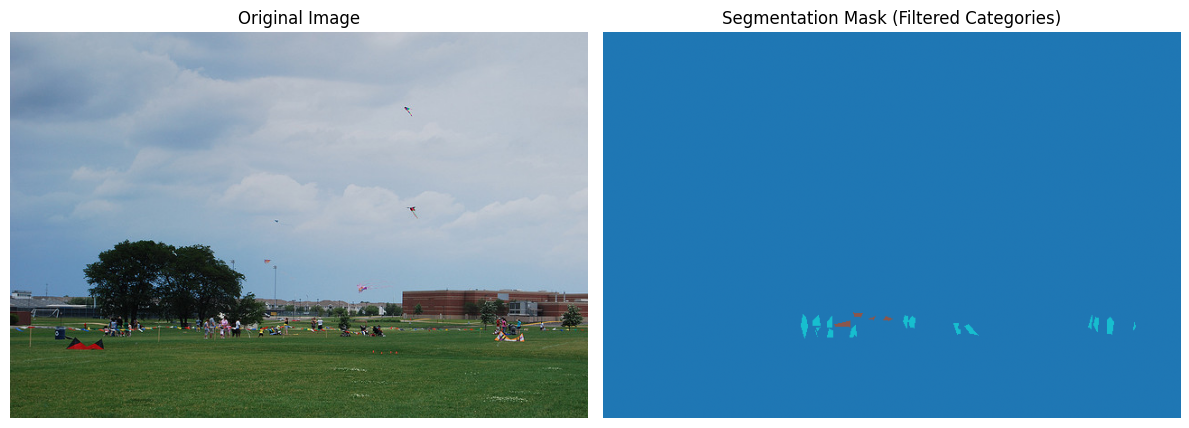

In [3]:
import os
import json
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from collections import defaultdict

DATASET_DIR = "/content/drive/MyDrive/Assignment/RM_Segmentation_Assignment_dataset"
IMAGE_FOLDER = os.path.join(DATASET_DIR, "train-300", "data")
LABELS_PATH = os.path.join(DATASET_DIR, "train-300", "labels.json")

# Category Mapping
target_categories = {
    15: 1,  # cake
    16: 2,  # car
    25: 3,  # dog
    41: 4   # person
}

# Load Annotations
with open(LABELS_PATH, 'r') as f:
    data = json.load(f)

image_id_to_filename = {img["id"]: img["file_name"] for img in data["images"]}
annotations = data["annotations"]

# Group annotations by image
image_to_annotations = defaultdict(list)
for ann in annotations:
    if ann["category_id"] in target_categories:
        image_to_annotations[ann["image_id"]].append(ann)

# Pick a sample image with relevant annotations
sample_image_id = next(iter(image_to_annotations))
sample_filename = image_id_to_filename[sample_image_id]
sample_annots = image_to_annotations[sample_image_id]

# Load the image
img_path = os.path.join(IMAGE_FOLDER, sample_filename)
img = Image.open(img_path)
width, height = img.size

# Mask Generations
def draw_polygons_on_mask(annotations, width, height):
    mask = Image.new("L", (width, height), 0)
    draw = ImageDraw.Draw(mask)
    for ann in annotations:
        class_idx = target_categories[ann["category_id"]]
        for seg in ann["segmentation"]:
            try:
                polygon = [(float(seg[i]), float(seg[i+1])) for i in range(0, len(seg), 2)]
                if len(polygon) >= 3:
                    draw.polygon(polygon, outline=class_idx, fill=class_idx)
            except (ValueError, IndexError):
                continue
    return np.array(mask, dtype=np.uint8)

mask = draw_polygons_on_mask(sample_annots, width, height)

# Visualsation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(img)
ax1.set_title("Original Image")
ax1.axis("off")

ax2.imshow(mask, cmap='tab10')
ax2.set_title("Segmentation Mask (Filtered Categories)")
ax2.axis("off")

plt.tight_layout()
plt.show()


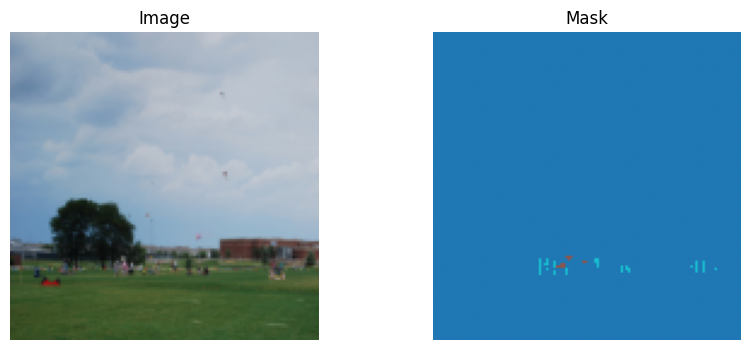

In [5]:
from torchvision import transforms

# Configuration
train_image_dir = "/content/drive/MyDrive/Assignment/RM_Segmentation_Assignment_dataset/train-300/data"
train_label_path = "/content/drive/MyDrive/Assignment/RM_Segmentation_Assignment_dataset/train-300/labels.json"
target_categories = {15: 1, 16: 2, 25: 3, 41: 4}

# Define simple transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Create dataset
train_dataset = SegmentationDataset(train_image_dir, train_label_path, target_categories, transform)

# Load one sample
img, mask = train_dataset[0]

# Visualize
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img.permute(1, 2, 0))
plt.title("Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap="tab10")
plt.title("Mask")
plt.axis("off")
plt.show()


In [6]:
# Configuration for validation
val_image_dir = "/content/drive/MyDrive/Assignment/RM_Segmentation_Assignment_dataset/validation-300/data"
val_label_path = "/content/drive/MyDrive/Assignment/RM_Segmentation_Assignment_dataset/validation-300/labels.json"

# Use same category filter
target_categories = {15: 1, 16: 2, 25: 3, 41: 4}

# Validation transform (same as training)
val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Create validation dataset
val_dataset = SegmentationDataset(val_image_dir, val_label_path, target_categories, transform=val_transform)


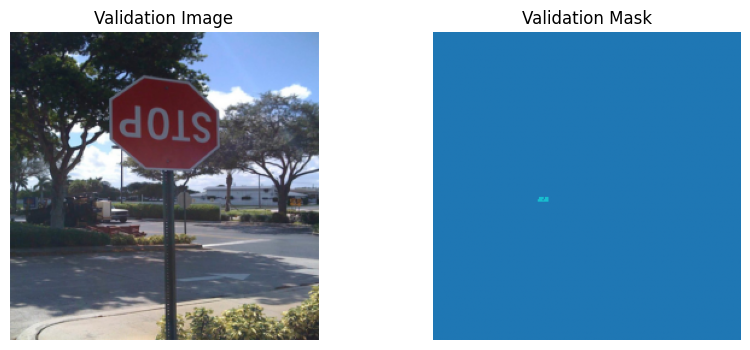

In [7]:
# Visualize a sample
val_img, val_mask = val_dataset[0]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(val_img.permute(1, 2, 0))
plt.title("Validation Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(val_mask, cmap="tab10")
plt.title("Validation Mask")
plt.axis("off")
plt.show()


In [ ]:
# Install segmentation model library
!pip install -q segmentation-models-pytorch

import os
import json
import numpy as np
from PIL import Image, ImageDraw
from collections import defaultdict
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt


In [ ]:
# Paths
DATASET_DIR = "/content/drive/MyDrive/Assignment/RM_Segmentation_Assignment_dataset"
train_image_dir = f"{DATASET_DIR}/train-300/data"
train_label_path = f"{DATASET_DIR}/train-300/labels.json"
val_image_dir = f"{DATASET_DIR}/validation-300/data"
val_label_path = f"{DATASET_DIR}/validation-300/labels.json"

# Category mapping
target_categories = {15: 1, 16: 2, 25: 3, 41: 4}

# Transform
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [4]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, label_path, target_categories, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.target_categories = target_categories

        with open(label_path, 'r') as f:
            data = json.load(f)

        self.image_id_to_filename = {img["id"]: img["file_name"] for img in data["images"]}
        annotations = data["annotations"]
        self.image_to_annotations = defaultdict(list)

        for ann in annotations:
            if ann["category_id"] in target_categories:
                self.image_to_annotations[ann["image_id"]].append(ann)

        self.image_ids = list(self.image_to_annotations.keys())

    def _generate_mask(self, annotations, width, height):
        mask = Image.new("L", (width, height), 0)
        draw = ImageDraw.Draw(mask)
        for ann in annotations:
            class_idx = self.target_categories[ann["category_id"]]
            for seg in ann["segmentation"]:
                try:
                    polygon = [(float(seg[i]), float(seg[i+1])) for i in range(0, len(seg), 2)]
                    if len(polygon) >= 3:
                        draw.polygon(polygon, fill=class_idx)
                except:
                    continue
        return np.array(mask, dtype=np.uint8)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        filename = self.image_id_to_filename[image_id]
        annotations = self.image_to_annotations[image_id]
        image_path = os.path.join(self.image_dir, filename)

        try:
            image = Image.open(image_path).convert("RGB")
        except Exception as e:
            print(f"Warning: Failed to load image {image_path} — skipping.")
            return self.__getitem__((idx + 1) % len(self))

        width, height = image.size
        mask = self._generate_mask(annotations, width, height)
        mask = Image.fromarray(mask)

        if self.transform:
            image = self.transform(image)
            mask = mask.resize((256, 256), Image.NEAREST)
            mask = torch.from_numpy(np.array(mask)).long()

        return image, mask

    def __len__(self):
        return len(self.image_ids)

# Load data
train_dataset = SegmentationDataset(train_image_dir, train_label_path, target_categories, transform)
val_dataset = SegmentationDataset(val_image_dir, val_label_path, target_categories, transform)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=0)

In [31]:
# Model
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = smp.Unet("resnet18", encoder_weights="imagenet", in_channels=3, classes=5).to(DEVICE)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train loop
EPOCHS = 30
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Train Loss: {total_loss / len(train_loader):.4f}")

Epoch 1, Train Loss: 0.6991
Epoch 2, Train Loss: 0.4311
Epoch 3, Train Loss: 0.4304
Epoch 4, Train Loss: 0.4128
Epoch 5, Train Loss: 0.4043
Epoch 6, Train Loss: 0.4029
Epoch 7, Train Loss: 0.4087
Epoch 8, Train Loss: 0.3998
Epoch 9, Train Loss: 0.3967
Epoch 10, Train Loss: 0.3834
Epoch 11, Train Loss: 0.3935
Epoch 12, Train Loss: 0.3909
Epoch 13, Train Loss: 0.3963
Epoch 14, Train Loss: 0.3895
Epoch 15, Train Loss: 0.3841
Epoch 16, Train Loss: 0.3775
Epoch 17, Train Loss: 0.3620
Epoch 18, Train Loss: 0.3538
Epoch 19, Train Loss: 0.3662
Epoch 20, Train Loss: 0.3518
Epoch 21, Train Loss: 0.3462
Epoch 22, Train Loss: 0.3297
Epoch 23, Train Loss: 0.3350
Epoch 24, Train Loss: 0.3425
Epoch 25, Train Loss: 0.3120
Epoch 26, Train Loss: 0.3016
Epoch 27, Train Loss: 0.2963
Epoch 28, Train Loss: 0.3339
Epoch 29, Train Loss: 0.3061
Epoch 30, Train Loss: 0.3041


In [32]:
model.eval()
val_loss = 0
with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        outputs = model(images)
        loss = criterion(outputs, masks)
        val_loss += loss.item()

print(f"Validation Loss: {val_loss / len(val_loader):.4f}")


Validation Loss: 0.7308


In [ ]:
torch.save(model.state_dict(), "unet_cake_car_dog_person.pth")

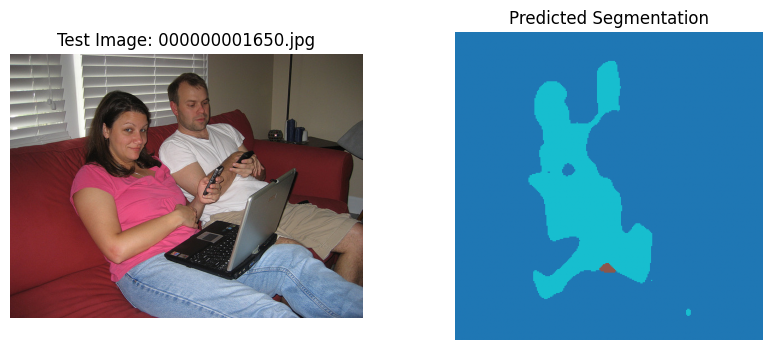

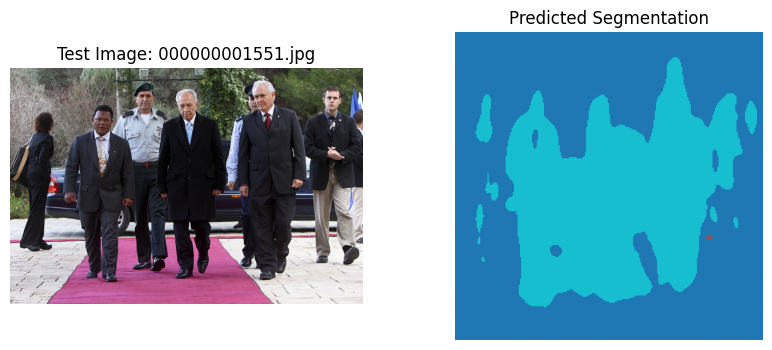

In [69]:
import os
import random
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

# Load trained model
model.load_state_dict(torch.load("unet_cake_car_dog_person.pth", map_location=DEVICE))
model.eval()

# Test directory and images
test_dir = "/content/drive/MyDrive/Assignment/RM_Segmentation_Assignment_dataset/test-30"
test_images = sorted([f for f in os.listdir(test_dir) if f.endswith(".jpg")])

# Preprocessing
resize = transforms.Resize((256, 256))
to_tensor = transforms.ToTensor()

# Pick random images
random_imgs = random.sample(test_images, 2)

for img_name in random_imgs:
    img_path = os.path.join(test_dir, img_name)
    image = Image.open(img_path).convert("RGB")
    input_tensor = to_tensor(resize(image)).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        output = model(input_tensor)
        pred_mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy()

    # Display
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Test Image: {img_name}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(pred_mask, cmap='tab10')
    plt.title("Predicted Segmentation")
    plt.axis("off")
    plt.show()
